STEP 1: Extract Useful data

In [ ]:
import os
import pandas as pd

data_dir = os.path.join(os.getcwd(), 'data')
save_dir = os.path.join(os.getcwd(), 'extracted_data')

os.makedirs(save_dir, exist_ok=True)

bearings = {
    '100Hz4kN': ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7'],
    '100Hz4.2kN': ['Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7'],
    '100Hz5kN': ['Bearing3_1', 'Bearing3_2', 'Bearing3_3']
}

dataframes = {}

for folder, bearings_list in bearings.items():
    folder_path = os.path.join(data_dir, folder)

    for bearing in bearings_list:
        bearing_path = os.path.join(folder_path, bearing)
        if not os.path.exists(bearing_path):
            print(f"Skipping {bearing_path}, does not exist.")
            continue
        
        data_files = [os.path.join(bearing_path, f) for f in os.listdir(bearing_path) if f.startswith('acc') and f.endswith('.csv')]
        
        if data_files:
            try:
                data_files.sort()
                
                def read_file(file):
                    with open(file, 'r') as f:
                        first_line = f.readline()
                    delimiter = ';' if ';' in first_line else ','
                    df = pd.read_csv(file, delimiter=delimiter, header=None)
                    if df.shape[1] == 1:
                        values = df.iloc[0, 0].split(';')
                        return pd.DataFrame([values[-2:]], columns=["Horizontal", "Vertical"])
                    else:
                        return pd.DataFrame(df.iloc[:, -2:].values, columns=["Horizontal", "Vertical"])
                
                bearing_df = pd.concat([read_file(data_file) for data_file in data_files], ignore_index=True)
                dataframes[bearing] = bearing_df
                
                output_file = os.path.join(save_dir, f'{bearing}_extracted.csv')
                bearing_df.to_csv(output_file, index=False)
                print(f"CSV file created for: {bearing}")
            
            except Exception as e:
                print(f"Error reading files for {bearing}: {e}")
        else:
            print(f"No CSV files found for {bearing} in {bearing_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/home/ustc15/research/combined_code/PRONOSTIA/data/35Hz12kN/Bearing1_1'

STEP 2: Visualize Data

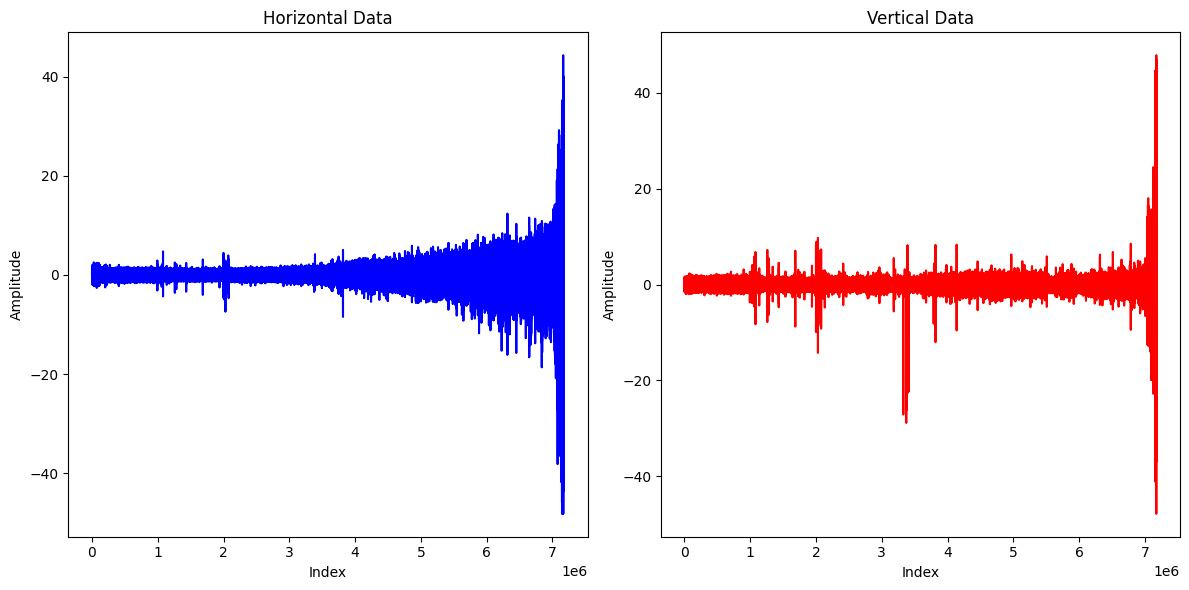

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

bearing = 'Bearing1_1'
save_dir = 'extracted_data'

df = pd.read_csv(f'{save_dir}/{bearing}_extracted.csv')

horizontal_data = df['Horizontal'].values
vertical_data = df['Vertical'].values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(horizontal_data, color='blue')
ax1.set_title('Horizontal Data')
ax1.set_xlabel('Index')
ax1.set_ylabel('Amplitude')

ax2.plot(vertical_data, color='red')
ax2.set_title('Vertical Data')
ax2.set_xlabel('Index')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()


STEP 5: Extract TF features via Wavelet Transform

In [ ]:
import os
import pandas as pd
import numpy as np
import pywt
from scipy.stats import entropy, kurtosis, skew

bearings = ['Bearing1_1','Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7',
            'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7', 
            'Bearing3_1', 'Bearing3_2', 'Bearing3_3'
            ]

input_folder = 'extracted_data'
output_folder = 'tf_features'

# Signal specifications
fs = 25600  # Sampling frequency (Hz)
delta_t = 1 / fs  # Sampling interval (s)
f_min = 33  # Minimum frequency of interest (Hz)
f_max = 300  # Maximum frequency of interest (Hz)
f_c = 0.81  # Central frequency of Morlet wavelet

# Calculate scale limits
s_min = f_c / (f_max * delta_t)
s_max = f_c / (f_min * delta_t)

# Generate scales
num_scales = 100
scales = np.logspace(np.log10(s_min), np.log10(s_max), num_scales)

for bearing in bearings:

    df = pd.read_csv(f'{input_folder}/Smooth_{bearing}.csv')


    signalARms = df['Horizontal'].values
    signalBRms = df['Vertical'].values


    wavelet = 'cmor'

    window_size = 1000
    step_size = 500

    # Prepare DataFrame
    data = []

    for start in range(0, len(signalARms) - window_size, step_size):
        window_signal1 = signalARms[start:start + window_size]
        window_signal2 = signalBRms[start:start + window_size]
        
        coeff1, freq1 = pywt.cwt(window_signal1, scales, wavelet, sampling_period=1/fs)
        coeff2, freq2 = pywt.cwt(window_signal2, scales, wavelet, sampling_period=1/fs)
        
        # Energy: Sum of squared coefficients
        energy1 = np.sum(np.abs(coeff1) ** 2)
        energy2 = np.sum(np.abs(coeff2) ** 2)
        
        # Dominant frequency: Scale with maximum energy
        dominant_scale1 = np.argmax(np.sum(np.abs(coeff1) ** 2, axis=1))
        dominant_scale2 = np.argmax(np.sum(np.abs(coeff2) ** 2, axis=1))
        dominant_frequency1 = freq1[dominant_scale1]
        dominant_frequency2 = freq2[dominant_scale2]
        
        # Entropy: Shannon entropy of the signal
        def calculate_entropy(signal):
            hist, bins = np.histogram(signal, bins=3, density=True)
            return entropy(hist + 1e-9)
        
        entropy1 = calculate_entropy(window_signal1)
        entropy2 = calculate_entropy(window_signal2)
        
        # Kurtosis and skewness
        kurtosis1 = kurtosis(window_signal1)
        kurtosis2 = kurtosis(window_signal2)
        skewness1 = skew(window_signal1)
        skewness2 = skew(window_signal2)
        
        # Mean and standard deviation
        mean1 = np.mean(window_signal1)
        mean2 = np.mean(window_signal2)
        std1 = np.std(window_signal1)
        std2 = np.std(window_signal2)
        
        # Feature vectors
        feature_vector1 = [energy1, dominant_frequency1, entropy1, kurtosis1, skewness1, mean1, std1]
        feature_vector2 = [energy2, dominant_frequency2, entropy2, kurtosis2, skewness2, mean2, std2]
        
        # Append data row
        data.append({
            'Horizontal': feature_vector1,
            'Vertical': feature_vector2,
        })

    # Convert to DataFrame
    df_features = pd.DataFrame(data)

    # Save to CSV
    output_file = f'{output_folder}/{bearing}_features.csv'
    df_features.to_csv(output_file, index=False)

    print(f"Features saved to {output_file}")


/home/ustc15/.local/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


Features saved to tf_features/Bearing1_1_features.csv


STEP 6: Visualize TF features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.preprocess import process_features



dfs = []
for i in range(1, 6):
    dfs.append(pd.read_csv(f'/home/ustc15/research/idea2/time_features/Bearing1_{i}_features_with_labels.csv'))

# Combine RUL arrays
rul = np.hstack([df['RUL'].values for df in dfs])
maxx = np.max(rul)
rul = rul / maxx

# Extract and process the 'Horizontal' columns
horizontal_data = [np.array(df['Horizontal'].apply(eval).tolist()) for df in dfs]

# Process features for horizontal data
processed_features = [process_features(data) for data in horizontal_data]

# Combine full feature sets
features_array_horizontal = np.vstack(processed_features)

# Select the first DataFrame
df = dfs[0]

# Extract and process the 'Horizontal' column
horizontal_data = np.array(df['Vertical'].apply(eval).tolist())

# Process features for horizontal data
processed_features = process_features(horizontal_data)

# Plotting the features
feature_names = [r"$E_{v}$", r"$f_{d_{v}}$", r"$h_{v}$", r"$k_{v}$", r"$sk_{v}$", r"$avg_{v}$", r"$\sigma_{v}$"]
num_features = processed_features.shape[1]
colors = plt.cm.inferno(np.linspace(0, 1, num_features))  # Reverting to the vibrant color palette

plt.figure(figsize=(13, 7))  # More compact image
# plt.style.use('seaborn-v0_8-deep')
for i in range(num_features):
    plt.subplot(num_features, 1, i+1)
    plt.grid()
    plt.plot(processed_features[:, i], label=feature_names[i], color=colors[i])
    plt.ylabel(feature_names[i])
    if i == num_features - 1:
        plt.xlabel('Frequency(Hz)')  # Only add x-axis label on the last subplot
    else:
        plt.xticks([])  # Hide x-ticks for all plots except the last one
    plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Convert Signal to Images

In [1]:
import os
import pandas as pd
import numpy as np
from bresenham import bresenham
from PIL import Image
from tqdm import tqdm  # For progress tracking

# Define the folder structure for your data
bearings = {
    '100Hz4kN': ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7'],
    '100Hz4.2kN': ['Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7'],
    '100Hz5kN': ['Bearing3_1', 'Bearing3_2', 'Bearing3_3']
}

data_dir = os.path.join(os.getcwd(), 'extracted_data')
output_dir = os.path.join(os.getcwd(), 'bearing_images')

# Parameters for signal-to-image conversion
resolution = 0.015625  # 64/1000
dummy = 1
window_size = 1000
stride = 500

# Create output directories
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Normalize data between 0 and 1
def normalize_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

for folder, bearings_list in bearings.items():
    folder_path = os.path.join(data_dir, folder)

    for bearing in bearings_list:
        bearing_path = os.path.join(data_dir, f"{bearing}_extracted.csv")

        # Check if the file exists
        if os.path.exists(bearing_path):
            # Load data
            bearing_df = pd.read_csv(bearing_path)

            # Prepare output folders
            bearing_dir = os.path.join(output_dir, bearing)
            horizontal_dir = os.path.join(bearing_dir, "Horizontal")
            vertical_dir = os.path.join(bearing_dir, "Vertical")
            os.makedirs(horizontal_dir, exist_ok=True)
            os.makedirs(vertical_dir, exist_ok=True)

            # Windowing the signals
            horizontal_signal = bearing_df['Horizontal'].values
            vertical_signal = bearing_df['Vertical'].values

            # Normalize the signals before windowing
            horizontal_signal = normalize_signal(horizontal_signal)
            vertical_signal = normalize_signal(vertical_signal)

            horizontal_windows = []
            vertical_windows = []

            for start in range(0, len(horizontal_signal) - window_size + 1, stride):
                horizontal_windows.append(horizontal_signal[start:start + window_size])
                vertical_windows.append(vertical_signal[start:start + window_size])

            # Convert horizontal signals to images
            print(f"Processing horizontal images for {bearing}...")
            for idx, window in tqdm(enumerate(horizontal_windows), total=len(horizontal_windows)):
                y1 = np.searchsorted(np.arange(0, 1 + resolution, resolution), window[:-1]) - 1
                y2 = np.searchsorted(np.arange(0, 1 + resolution, resolution), window[1:]) - 1
                pairs = list(zip(
                    np.arange(0, len(window) * dummy, dummy)[:-1], y1,
                    np.arange(dummy, len(window) * dummy + 1, dummy)[:-1], y2
                ))

                # Create an image using Bresenham's line algorithm
                img_x_ax = np.arange(0, len(window) * dummy)
                img_y_ax = np.arange(0, 1 + resolution, resolution)
                zeros = np.zeros((len(img_y_ax), len(img_x_ax)))
                for pair in pairs:
                    x0, y0, x1, y1 = pair
                    bresenham_output = list(bresenham(x0, y0, x1, y1))
                    img_x, img_y = zip(*bresenham_output)
                    zeros[img_y, img_x] = 255

                # Save the image
                img_path = os.path.join(horizontal_dir, f"window_{idx}.png")
                Image.fromarray(np.flipud(zeros)).convert("L").save(img_path, optimize=True, quality=95)

        else:
            print(f"No CSV file found for {bearing} in {folder_path}")

Processing horizontal images for Bearing1_1...


100%|██████████| 14350/14350 [01:25<00:00, 168.66it/s]


Processing horizontal images for Bearing1_2...


100%|██████████| 4458/4458 [00:29<00:00, 151.82it/s]


Processing horizontal images for Bearing1_3...


100%|██████████| 12159/12159 [01:16<00:00, 159.71it/s]


Processing horizontal images for Bearing1_4...


100%|██████████| 7310/7310 [00:55<00:00, 131.03it/s]


Processing horizontal images for Bearing1_5...


100%|██████████| 12609/12609 [01:25<00:00, 147.67it/s]


Processing horizontal images for Bearing1_6...


100%|██████████| 12532/12532 [01:39<00:00, 126.18it/s]


Processing horizontal images for Bearing1_7...


100%|██████████| 11565/11565 [01:13<00:00, 157.28it/s]


Processing horizontal images for Bearing2_1...


100%|██████████| 4663/4663 [00:34<00:00, 133.97it/s]


Processing horizontal images for Bearing2_2...


100%|██████████| 4079/4079 [00:30<00:00, 132.05it/s]


Processing horizontal images for Bearing2_3...


100%|██████████| 10008/10008 [00:59<00:00, 168.76it/s]


Processing horizontal images for Bearing2_4...


100%|██████████| 3844/3844 [00:32<00:00, 116.69it/s]


Processing horizontal images for Bearing2_5...


100%|██████████| 11831/11831 [01:29<00:00, 132.79it/s]


Processing horizontal images for Bearing2_6...


100%|██████████| 3588/3588 [00:28<00:00, 124.41it/s]


Processing horizontal images for Bearing2_7...


100%|██████████| 1176/1176 [00:07<00:00, 152.52it/s]


Processing horizontal images for Bearing3_1...


100%|██████████| 2635/2635 [00:16<00:00, 163.69it/s]


Processing horizontal images for Bearing3_2...


100%|██████████| 8380/8380 [00:53<00:00, 156.12it/s]


Processing horizontal images for Bearing3_3...


100%|██████████| 2221/2221 [00:20<00:00, 107.27it/s]


In [2]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Parameters
image_size = (500, 63)  # Resize images to a standard size

# Paths
output_dir = os.path.join(os.getcwd(), 'bearing_images')
save_dir = os.path.join(os.getcwd(), 'image_features')

# Bearings to process
bearings = {'Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7',
           'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7',
           'Bearing3_1', 'Bearing3_2', 'Bearing3_3'}

# Function to load images
def load_images(output_dir, save_dir, bearings, resize_to=image_size):
    images_horizontal = []

    for bearing in tqdm(bearings, desc="Processing Bearings"):
        bearing_path = os.path.join(output_dir, bearing)
        if os.path.isdir(bearing_path):
            # Paths for horizontal subdirectory
            horizontal_dir = os.path.join(bearing_path, "Horizontal")

            # Process horizontal images
            if os.path.isdir(horizontal_dir):
                for img_file in tqdm(os.listdir(horizontal_dir), desc=f"Processing Horizontal for {bearing}", leave=False):
                    if img_file.endswith('.png'):
                        try:
                            # Load and preprocess image
                            img_path = os.path.join(horizontal_dir, img_file)
                            img = Image.open(img_path).resize(resize_to, Image.LANCZOS)
                            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

                            images_horizontal.append(img_array)
                        except Exception as e:
                            print(f"Error processing file {img_file}: {e}")

                # Save horizontal images separately for each bearing
                bearing_horizontal_images = np.array(images_horizontal)
                np.save(f'{save_dir}/{bearing}_horizontal_images.npy', bearing_horizontal_images)

                # Reset list for next bearing
                images_horizontal = []

    return np.array(images_horizontal)

# Load data
horizontal_data = load_images(output_dir, save_dir, bearings)

Processing Bearings: 100%|██████████| 17/17 [02:41<00:00,  9.48s/it]


STEP 6: Generate Piecewise RUL Labels

In [5]:
import os
import pandas as pd
import numpy as np

# Folder where individual bearing feature files are saved
features_folder = 'tf_features'

# List of individual bearing file names (without "_features.csv")
bearings = [
    'Bearing1_1','Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7',
    'Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7', 
    'Bearing3_1', 'Bearing3_2', 'Bearing3_3'
]

# RUL parameters
initial_rul = 100
cutoff_percent = 0.3  # First 30% gets constant RUL

for bearing in bearings:
    file_path = os.path.join(features_folder, f'{bearing}_features.csv')
    
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}, skipping.")
        continue
    
    # Load the CSV
    df = pd.read_csv(file_path)
    total_len = len(df)
    boundary_index = int(total_len * cutoff_percent)

    # Initialize RUL column
    rul = np.zeros(total_len)

    # Assign RUL values
    rul[:boundary_index] = initial_rul  # First 30%
    remaining = total_len - boundary_index
    if remaining > 0:
        rul[boundary_index:] = np.linspace(initial_rul, 0, remaining)

    # Add to DataFrame
    df['RUL'] = rul

    # Save it back to the same file
    df.to_csv(file_path, index=False)
    print(f"RUL added to {file_path}")


RUL added to tf_features/Bearing1_1_features.csv
RUL added to tf_features/Bearing1_2_features.csv
RUL added to tf_features/Bearing1_3_features.csv
RUL added to tf_features/Bearing1_4_features.csv
RUL added to tf_features/Bearing1_5_features.csv
RUL added to tf_features/Bearing1_6_features.csv
RUL added to tf_features/Bearing1_7_features.csv
RUL added to tf_features/Bearing2_1_features.csv
RUL added to tf_features/Bearing2_2_features.csv
RUL added to tf_features/Bearing2_3_features.csv
RUL added to tf_features/Bearing2_4_features.csv
RUL added to tf_features/Bearing2_5_features.csv
RUL added to tf_features/Bearing2_6_features.csv
RUL added to tf_features/Bearing2_7_features.csv
RUL added to tf_features/Bearing3_1_features.csv
RUL added to tf_features/Bearing3_2_features.csv
RUL added to tf_features/Bearing3_3_features.csv


STEP 7: Visualize RUL 

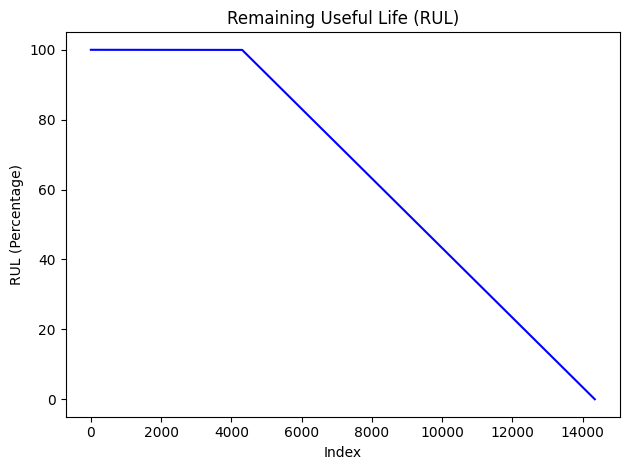

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

bearing = 'Bearing1_1'
data_dir = 'tf_features'

df = pd.read_csv(f'{data_dir}/{bearing}_features.csv')

rul = df['RUL'].values

plt.plot(rul, color='blue')
plt.title('Remaining Useful Life (RUL)')
plt.xlabel('Index')
plt.ylabel('RUL (Percentage)')
plt.tight_layout()
plt.show()

STEP 4: Train Multimodal

In [ ]:
import numpy as np
import pandas as pd
import os
from utils.preprocess import process_features,correct_dims3
from utils.reset_callback import ResetStatesCallback
import pandas as pd
from utils.multimod_datagen import MultimodalDataGen
from sklearn.model_selection import KFold
from keras._tf_keras.keras.optimizers import RMSprop
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Conv1D, Dense, Concatenate, Conv2D, BatchNormalization, Activation, GlobalMaxPooling1D, LayerNormalization, MultiHeadAttention, Add, Reshape, Lambda, MaxPooling2D, LSTM, MaxPooling1D
from keras._tf_keras.keras.regularizers import l2
import tensorflow as tf


#load_directories
dir = os.getcwd()
image_dir = os.path.join(dir,'image_features')
time_dir = os.path.join(dir,'tf_features')
weights_dir = os.path.join(dir,'model_weights')
stat_dir = os.path.join(dir,'statistics')

#loading_data
bearings = {'Bearing1_1','Bearing1_2','Bearing1_4'}

X_visual = np.vstack([np.load(f'{image_dir}/{bearing}_horizontal_images.npy', allow_pickle=True) for bearing in sorted(bearings)])
X_visual = np.array([correct_dims3(img) for img in X_visual]) 

dfs = [pd.read_csv(f'{time_dir}/{bearing}_features.csv') for bearing in sorted(bearings)]
y = np.concatenate([df['RUL'].values / np.max(df['RUL'].values) for df in dfs])
vertical_data = [np.array(df['Vertical'].apply(eval).tolist()) for df in dfs]
X_time = np.vstack([process_features(data) for data in vertical_data])
X_time = np.array([correct_dims3(data) for data in X_time])


#input_shapes
img_shape = np.shape(X_visual[0])
time_shape = np.shape(X_time[0])

print(f'Image shape: {img_shape}')

reg_strength = 0.01

# Image Branch
img_shape = (63,500, 1)
img_input = Input(shape=img_shape)
img_conv1 = Conv2D(32, (5, 5), padding='same', dilation_rate=(4, 4), kernel_regularizer=l2(reg_strength))(img_input)
img_conv1 = BatchNormalization()(img_conv1)
img_conv1 = Activation('relu')(img_conv1)
img_conv1 = MaxPooling2D((3, 3), padding='same')(img_conv1)

img_conv2 = Conv2D(32, (3, 3), padding='same', dilation_rate=(3, 3), kernel_regularizer=l2(reg_strength))(img_conv1)
img_conv2 = BatchNormalization()(img_conv2)
img_conv2 = Activation('relu')(img_conv2)
img_conv2 = MaxPooling2D((3, 3), name='ires1ip', padding='same')(img_conv2)

img_res1 = Conv2D(32, (1, 1), padding='same', kernel_regularizer=l2(reg_strength))(img_input)
img_res1 = Lambda(lambda x: tf.image.resize(x, (img_conv2.shape[1], img_conv2.shape[2])))(img_res1)
img_res1 = Add(name='ires1')([img_res1, img_conv2])

img_conv3 = Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(reg_strength))(img_res1)
img_conv3 = BatchNormalization()(img_conv3)
img_conv3 = Activation('relu')(img_conv3)
img_conv3 = MaxPooling2D((3, 3), padding='same')(img_conv3)

img_conv4 = Conv2D(64, (2, 2), padding='same', dilation_rate=(1, 1), kernel_regularizer=l2(reg_strength))(img_conv3)
img_conv4 = BatchNormalization()(img_conv4)
img_conv4 = Activation('relu')(img_conv4)
img_conv4 = MaxPooling2D((2, 2), name='ires2ip', padding='same')(img_conv4)

img_res2 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(reg_strength))(img_res1)
img_res2 = Lambda(lambda x: tf.image.resize(x, (img_conv4.shape[1], img_conv4.shape[2])))(img_res2)
img_res2 = Add(name='ires2')([img_res2, img_conv4])
img_output = Reshape((-1, int(img_res2.shape[-1])))(img_res2)

# Time Branch
time_shape = (7, 1)
time_input = Input(shape=time_shape)
time_conv1 = Conv1D(32, 2, padding='same', dilation_rate=2, kernel_regularizer=l2(reg_strength))(time_input)
time_conv1 = BatchNormalization()(time_conv1)
time_conv1 = Activation('relu')(time_conv1)
time_conv1 = MaxPooling1D(pool_size=1)(time_conv1)

time_conv2 = Conv1D(32, 2, padding='same', dilation_rate=2, kernel_regularizer=l2(reg_strength))(time_conv1)
time_conv2 = BatchNormalization()(time_conv2)
time_conv2 = Activation('relu')(time_conv2)
time_conv2 = MaxPooling1D(pool_size=1, name='tres1ip')(time_conv2)

time_res1 = Conv1D(32, 1, padding='same', kernel_regularizer=l2(reg_strength))(time_input)
time_res1 = Add(name='tres1')([time_conv2, time_res1])

time_conv3 = Conv1D(64, 2, padding='same', dilation_rate=1, kernel_regularizer=l2(reg_strength))(time_res1)
time_conv3 = BatchNormalization()(time_conv3)
time_conv3 = Activation('relu')(time_conv3)
time_conv3 = MaxPooling1D(pool_size=1)(time_conv3)

time_conv4 = Conv1D(64, 2, padding='same', dilation_rate=1, kernel_regularizer=l2(reg_strength))(time_conv3)
time_conv4 = BatchNormalization()(time_conv4)
time_conv4 = Activation('relu')(time_conv4)
time_conv4 = MaxPooling1D(pool_size=1, name='tres2ip')(time_conv4)

time_res2 = Conv1D(64, 1, padding='same', kernel_regularizer=l2(reg_strength))(time_res1)
time_output = Add(name='tres2')([time_res2, time_conv4])

# Multimodal Model
concat = Concatenate(axis=1, name='mres1ip')([img_output, time_output])
lstm1 = LSTM(100, activation='tanh', return_sequences=True)(concat)
lstm2 = LSTM(64, activation='tanh', return_sequences=True)(lstm1)
lstm2 = LSTM(64, activation='tanh', return_sequences=True)(lstm2)
res_m = Add(name='mres1')([concat, lstm2])

norm_m = LayerNormalization()(res_m)
mha_m = MultiHeadAttention(num_heads=8, key_dim=64)(norm_m, norm_m, norm_m)
out_m = GlobalMaxPooling1D()(mha_m)
out_m = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(out_m)
out_m = Dense(32, activation='relu', kernel_regularizer=l2(reg_strength))(out_m)
out_m = Dense(1)(out_m)

model = Model(inputs=[img_input, time_input], outputs=out_m)
model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse', metrics=['mae'])

# model.load_weights(f'{weights_dir}/multimod_pronostia.hdf5.keras')


#callbacks
reset_states_callback = ResetStatesCallback()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-10)
checkpoint_callback = ModelCheckpoint(f'{weights_dir}/pronosita_multimodal_weights.hdf5.keras', monitor='loss', save_best_only=True, mode='auto',save_weights_only=False)


K = 8
kf = KFold(n_splits=K, shuffle=True, random_state=42)
fold_no = 1


# Create an empty list to store all histories
all_histories = []

# Training loop for K-Folds
for train_idx, val_idx in kf.split(X_visual):
    print(f"\nTraining Fold {fold_no}/{K}")
    X_train_vis, X_val_vis = X_visual[train_idx], X_visual[val_idx]
    X_train_ts, X_val_ts = X_time[train_idx], X_time[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_gen = MultimodalDataGen(X_train_vis, X_train_ts, y_train, batch_size=32, augmentation=True)
    val_gen = MultimodalDataGen(X_val_vis, X_val_ts, y_val, batch_size=32, augmentation=False)

    history = model.fit(
        train_gen,
        epochs=5,
        batch_size=32,
        validation_data=val_gen,
        callbacks=[reduce_lr_callback, checkpoint_callback, reset_states_callback]
    )

    # Append history along with fold number
    for epoch in range(len(history.history['loss'])):
        all_histories.append({
            'Fold': fold_no,
            'Epoch': epoch + 1,
            'Loss': history.history['loss'][epoch],
            'Val_Loss': history.history['val_loss'][epoch],
        })
    
    fold_no += 1

# Create a DataFrame and save it as a CSV
df = pd.DataFrame(all_histories)
df.to_csv(f'{stat_dir}/pronostia_multimodal_training_history.csv', index=False)

STEP 10: Visualize Training Statistics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import pandas as pd


# Read CSV file
dir = os.getcwd()
stats_dir = os.path.join(dir, 'statistics')

df = pd.read_csv(f'{stats_dir}/pronostia_multimodal_training_history.csv')

# Extract loss and validation loss
loss = df['loss'].values
val_loss = df['val_loss'].values
MAE = df['mae'].values
val_MAE = df['val_mae'].values
epochs = np.arange(1, len(loss) + 1)

plt.style.use('seaborn-v0_8-deep')
# Plot loss and validation loss
plt.plot(epochs, loss, label="RMSE", linestyle='-')
plt.plot(epochs, val_loss, label="Validation RMSE", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("RMSE and Validation RMSE over Epochs (PRONOSTIA)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, MAE, label="MAE", linestyle='-')
plt.plot(epochs, val_MAE, label="Validation MAE", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE and Validation MAE over Epochs (PRONOSTIA)")
plt.legend()
plt.grid(True)
plt.show()


STEP 11: Ensemble Training

In [ ]:
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from keras._tf_keras.keras.models import Model
import pickle
from utils.preprocess import process_features,correct_dims3
from multimodal import multimod_rul
from keras._tf_keras.keras.optimizers import RMSprop


#load_directories
dir = os.getcwd()
image_dir = os.path.join(dir,'image_features')
time_dir = os.path.join(dir,'tf_features')
weights_dir = os.path.join(dir,'model_weights')

bearings = {'Bearing1_1','Bearing1_2','Bearing1_3','Bearing1_4'}


X_visual = np.vstack([np.load(f'{image_dir}/{bearing}_horizontal_images.npy', allow_pickle=True) for bearing in sorted(bearings)])
X_visual = np.array([correct_dims3(img) for img in X_visual]) 

dfs = [pd.read_csv(f'{time_dir}/{bearing}_features.csv') for bearing in sorted(bearings)]
y = np.concatenate([df['RUL'].values / np.max(df['RUL'].values) for df in dfs])
vertical_data = [np.array(df['Vertical'].apply(eval).tolist()) for df in dfs]
X_time = np.vstack([process_features(data) for data in vertical_data])
X_time = np.array([correct_dims3(data) for data in X_time])


img_shape = np.shape(X_visual[0])

model = multimod_rul(img_shape=img_shape, time_shape=(7, 1))
model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse', metrics=['mae'])

model.load_weights(f'{weights_dir}/pronosita_multimodal_weights.hdf5.keras')


feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)  # Change index to select the layer
X_train_features = feature_extractor.predict([X_visual,X_time])

regressor = RandomForestRegressor(n_estimators=800, random_state=42)
regressor.fit(X_train_features, y)

# save
with open(f'{weights_dir}/pronosita_multimodal_skl.pkl','wb') as f:
    pickle.dump(regressor,f)

/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 67 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step


STEP 12: Ablation experiments

2025-05-27 17:57:43.673430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 17:57:43.674583: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 17:57:43.679118: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 17:57:43.689770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748339863.704045    5136 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748339863.70

449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 98ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 98ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 36s 94ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 36s 94ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step
395/395 ━━━━━

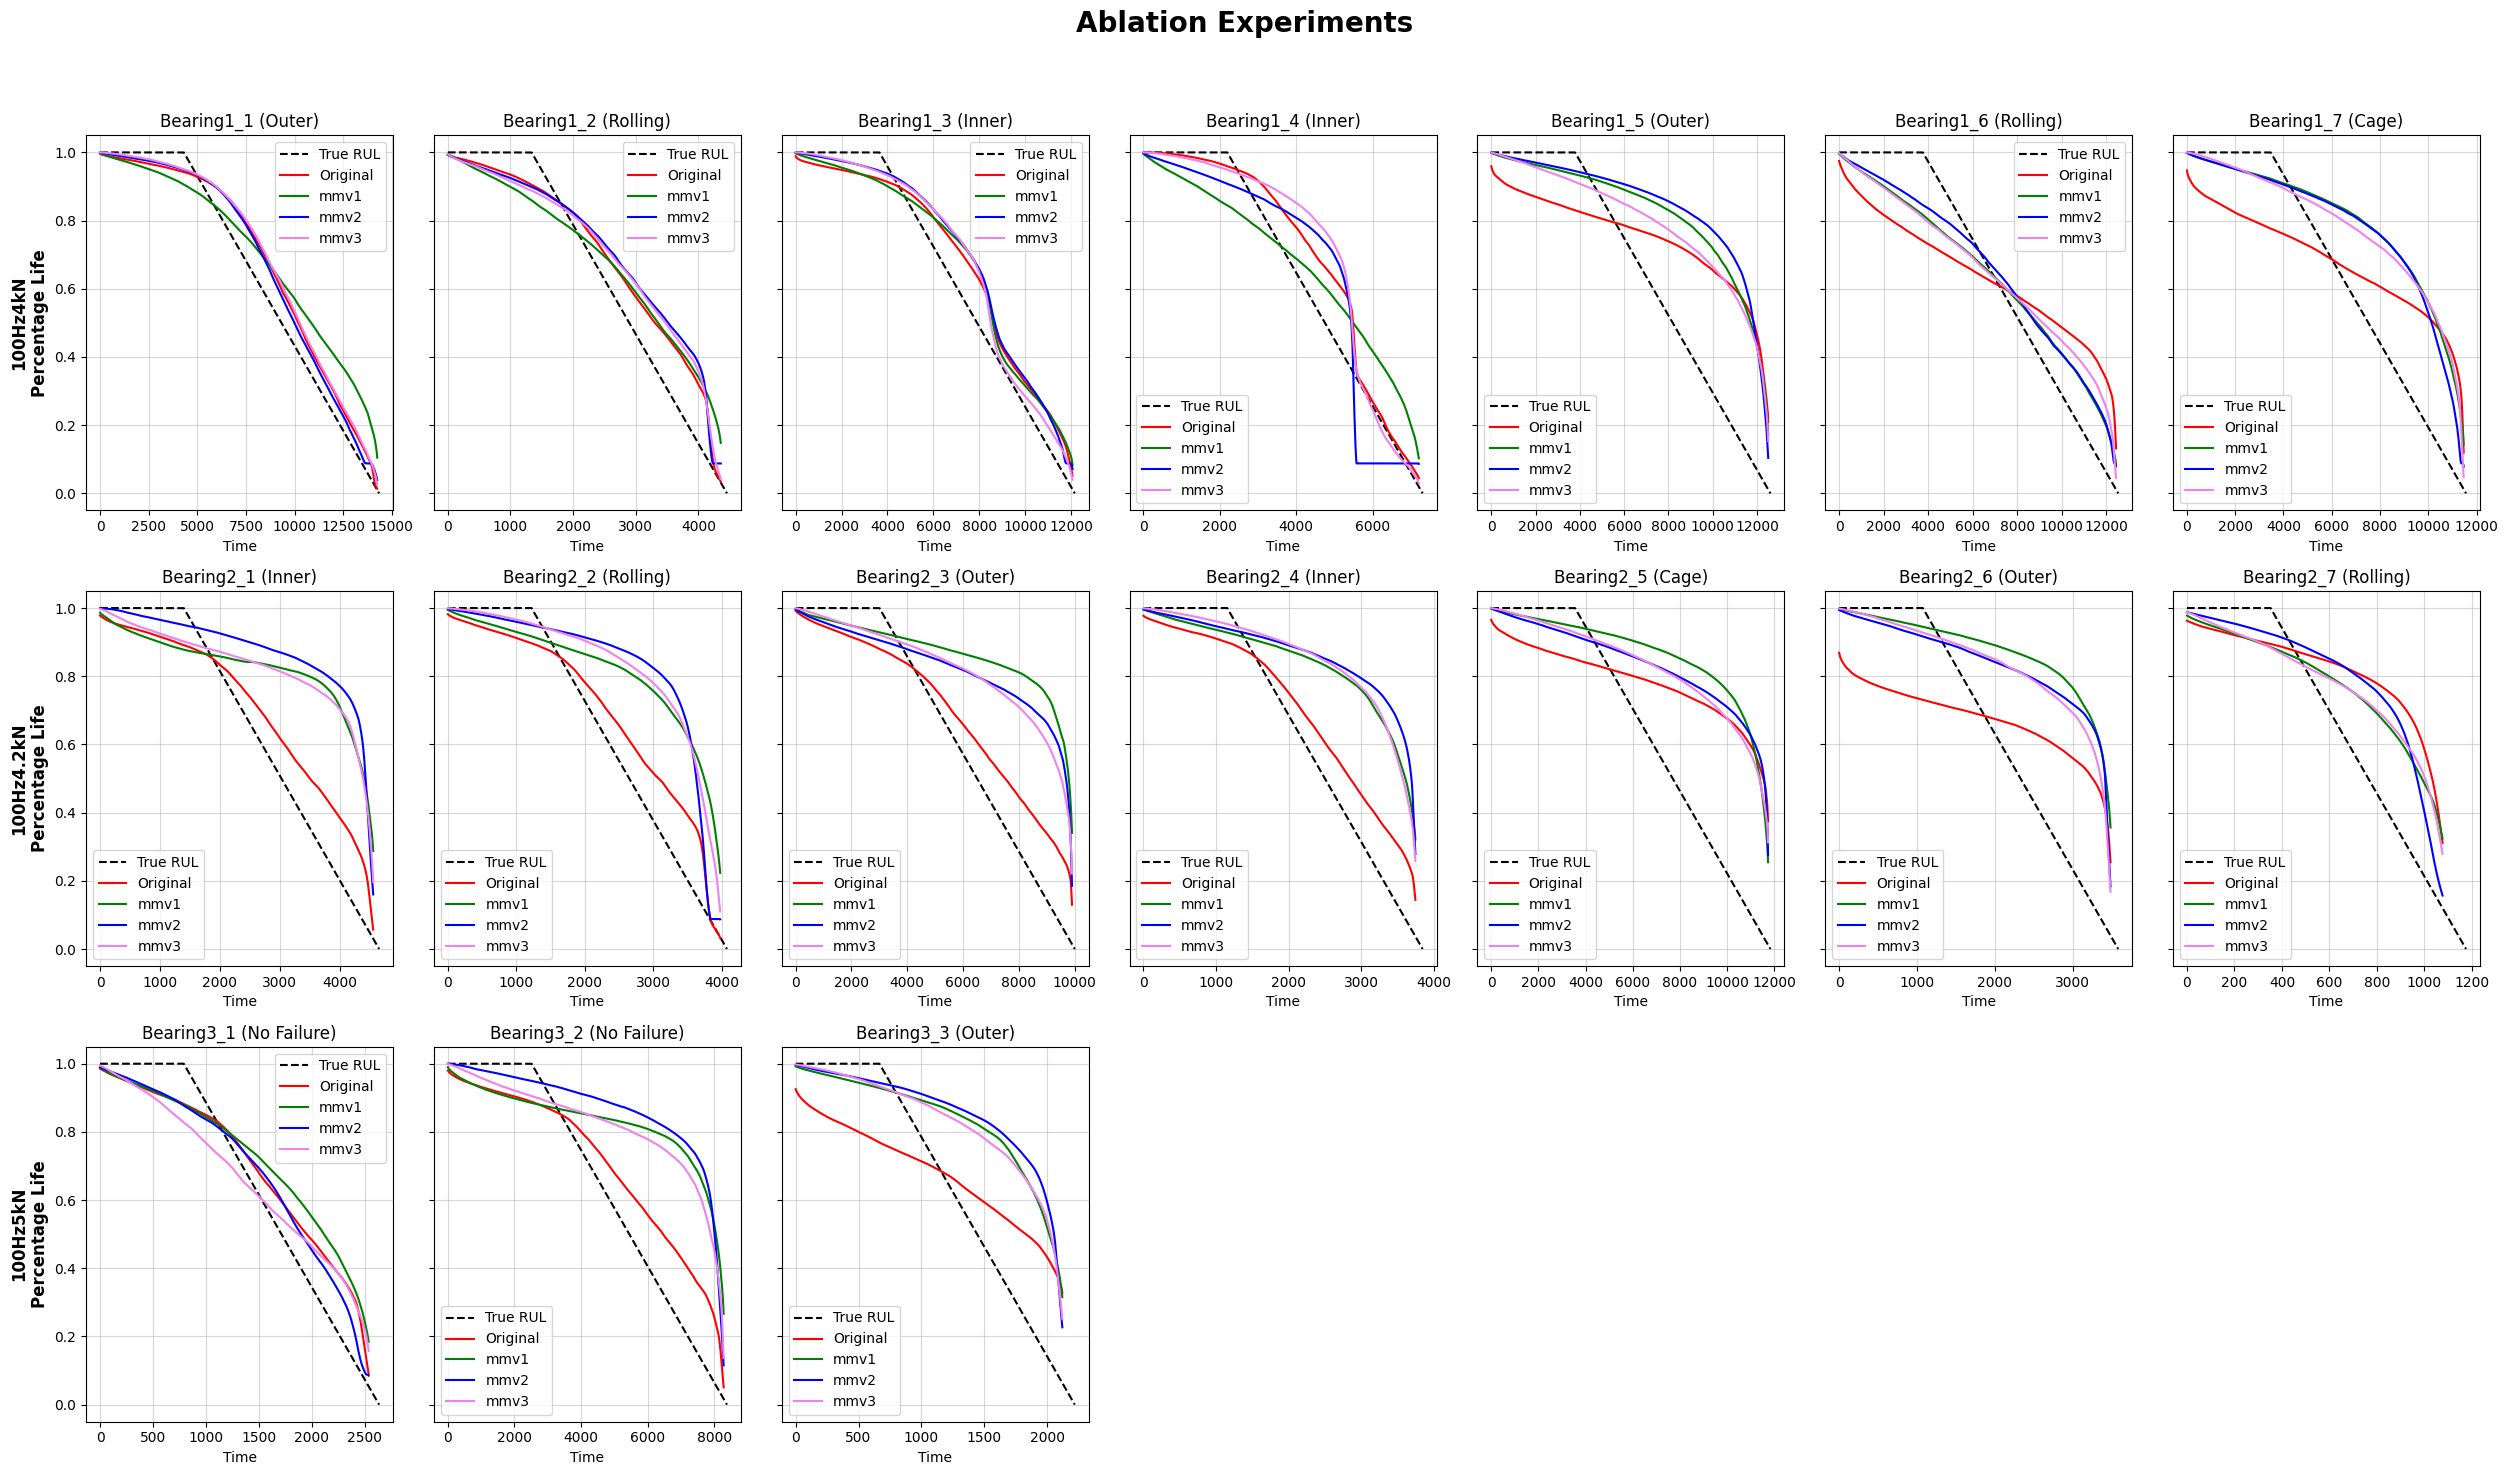

Idea 2: Ablation experiments results have been saved.csv


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model, load_model
from utils.preprocess import process_features,correct_dims3
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from multimodal import multimod_rul
from ablation_multimodal import mmv1,mmv2,mmv3


# Load directories
dir = os.getcwd()
time_dir = os.path.join(dir, 'tf_features')
image_dir = os.path.join(dir, 'image_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')

bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer'},
        {'name': 'Bearing1_2', 'failure': 'Rolling'},
        {'name': 'Bearing1_3', 'failure': 'Inner'},
        {'name': 'Bearing1_4', 'failure': 'Inner'},
        {'name': 'Bearing1_5', 'failure': 'Outer'},
        {'name': 'Bearing1_6', 'failure': 'Rolling'},
        {'name': 'Bearing1_7', 'failure': 'Cage'},
    ],
    '100Hz4.2kN': [
        {'name': 'Bearing2_1', 'failure': 'Inner'},
        {'name': 'Bearing2_2', 'failure': 'Rolling'},
        {'name': 'Bearing2_3', 'failure': 'Outer'},
        {'name': 'Bearing2_4', 'failure': 'Inner'},
        {'name': 'Bearing2_5', 'failure': 'Cage'},
        {'name': 'Bearing2_6', 'failure': 'Outer'},
        {'name': 'Bearing2_7', 'failure': 'Rolling'},
    ],
    '100Hz5kN': [
        {'name': 'Bearing3_1', 'failure': 'No Failure'},
        {'name': 'Bearing3_2', 'failure': 'No Failure'},
        {'name': 'Bearing3_3', 'failure': 'Outer'},
    ]
}



def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')



mmv0_keras = multimod_rul()
mmv0_keras.load_weights(f'{weights_dir}/pronosita_multimodal_weights.hdf5.keras')
mmv0_extractor = Model(inputs=mmv0_keras.input, outputs=mmv0_keras.get_layer(index=-2).output)  
mmv0_regressor = joblib.load(f'{weights_dir}/pronosita_multimodal_skl.pkl')


mmv1_keras = mmv1()
mmv1_keras.load_weights(f'{weights_dir}/pronostia_mmv1_weights.hdf5.keras')
mmv1_extractor = Model(inputs=mmv1_keras.input, outputs=mmv1_keras.get_layer(index=-2).output)  # Change index to select the layer
mmv1_regressor = joblib.load(f'{weights_dir}/pronostia_mmv1_skl.pkl')

mmv2_keras = mmv2()
mmv2_keras.load_weights(f'{weights_dir}/pronostia_mmv2_weights.hdf5.keras')
mmv2_extractor = Model(inputs=mmv2_keras.input, outputs=mmv2_keras.get_layer(index=-2).output)  # Change index to select the layer
mmv2_regressor = joblib.load(f'{weights_dir}/pronostia_mmv2_skl.pkl')

mmv3_keras = mmv3()
mmv3_keras.load_weights(f'{weights_dir}/pronostia_mmv3_weights.hdf5.keras')
mmv3_extractor = Model(inputs=mmv3_keras.input, outputs=mmv3_keras.get_layer(index=-2).output)  # Change index to select the layer
mmv3_regressor = joblib.load(f'{weights_dir}/pronostia_mmv3_skl.pkl')



error_data = []

# Prepare subplots
plt.style.use('seaborn-v0_8-deep')
rows = len(bearings)
columns = max(len(bearing_list) for bearing_list in bearings.values())  # Max number of bearings in any condition
fig, axes = plt.subplots(rows, columns, figsize=(25, 5 * rows), sharey=True)
fig.suptitle('Ablation Experiments', fontsize=20, fontweight='bold')

# Loop through conditions and bearings
for row, (condition, bearing_list) in enumerate(bearings.items()):
    for col in range(columns):
        if col < len(bearing_list):  # Populate only for existing bearings
            bearing_info = bearing_list[col]
            bearing = bearing_info['name']
            failure = bearing_info['failure']

            try:
                df = pd.read_csv(f'{time_dir}/{bearing}_features.csv')

                vertical_features = np.array(df['Vertical'].apply(eval).tolist())
                X_time = process_features(vertical_features)
                y_true = df['RUL'].values / np.max(df['RUL'].values)


                X_images = np.load(f'{image_dir}/{bearing}_horizontal_images.npy')
                X_images = np.array([correct_dims3(data) for data in X_images])

                y_true = df['RUL'].values / np.max(df['RUL'].values)

                mmv0_X = mmv0_extractor.predict([X_images,X_time]).squeeze()
                mmv1_X = mmv1_extractor.predict([X_images,X_time]).squeeze()
                mmv2_X = mmv2_extractor.predict([X_images,X_time]).squeeze()
                mmv3_X = mmv3_extractor.predict([X_images,X_time]).squeeze()
                mmv4_X = mmv0_keras.predict([X_images,X_time]).squeeze()

                pred_mmv0 = mmv0_regressor.predict(mmv0_X).squeeze()
                pred_mmv1 = mmv1_regressor.predict(mmv1_X).squeeze()
                pred_mmv2 = mmv2_regressor.predict(mmv2_X).squeeze()
                pred_mmv3 = mmv3_regressor.predict(mmv3_X).squeeze()

                pred_mmv0 = np.sort(pred_mmv0.squeeze())[::-1]
                pred_mmv1 = np.sort(pred_mmv1.squeeze())[::-1]
                pred_mmv2 = np.sort(pred_mmv2.squeeze())[::-1]
                pred_mmv3 = np.sort(pred_mmv3.squeeze())[::-1]
                pred_mmv4 = np.sort(mmv4_X.squeeze())[::-1]

                # Compute errors and store in list
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "Original",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv0),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv0)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "mmv1",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv1),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv1)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "mmv2",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv2),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv2)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "mmv3",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv3),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv3)
                })
                error_data.append({
                    "Condition": condition,
                    "Bearing": bearing,
                    "Model": "mmv4",
                    "Mean Squared Error": mean_squared_error(y_true, pred_mmv4),
                    "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv4)
                })

                axes[row, col].plot(y_true, label='True RUL', color='black', linestyle='--')
                axes[row, col].plot(moving_average(pred_mmv0), label='Original', color='red', linestyle='-')
                axes[row, col].plot(moving_average(pred_mmv1), label='mmv1', color='green', linestyle='-')
                axes[row, col].plot(moving_average(pred_mmv2), label='mmv2', color='blue', linestyle='-')
                axes[row, col].plot(moving_average(pred_mmv3), label='mmv3', color='violet', linestyle='-')

                axes[row, col].set_title(f'{bearing} ({failure})')
                axes[row, col].grid(alpha=0.5)
                axes[row, col].legend(loc='best')
                axes[row, col].set_xlabel('Time')
                if col == 0:  # Set ylabel for first column only
                    axes[row, col].set_ylabel(f'{condition}\nPercentage Life', fontsize=12, fontweight='bold')
            except Exception as e:
                print(f"Error processing {bearing}: {e}")
        else:  # Clear unused subplots
            axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
# Convert error data to DataFrame and save as CSV grouped by condition
df_errors = pd.DataFrame(error_data)
df_errors.to_csv(f'{stats_dir}/pronostia_multimodal_ablation.csv', index=False)

print("Idea 2: Ablation experiments results have been saved.csv")

STEP : NOISE TEST

2025-05-27 19:17:48.752622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 19:17:48.753586: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 19:17:48.756566: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 19:17:48.764465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748344668.777821   15623 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748344668.78

449/449 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step
392/392 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/st

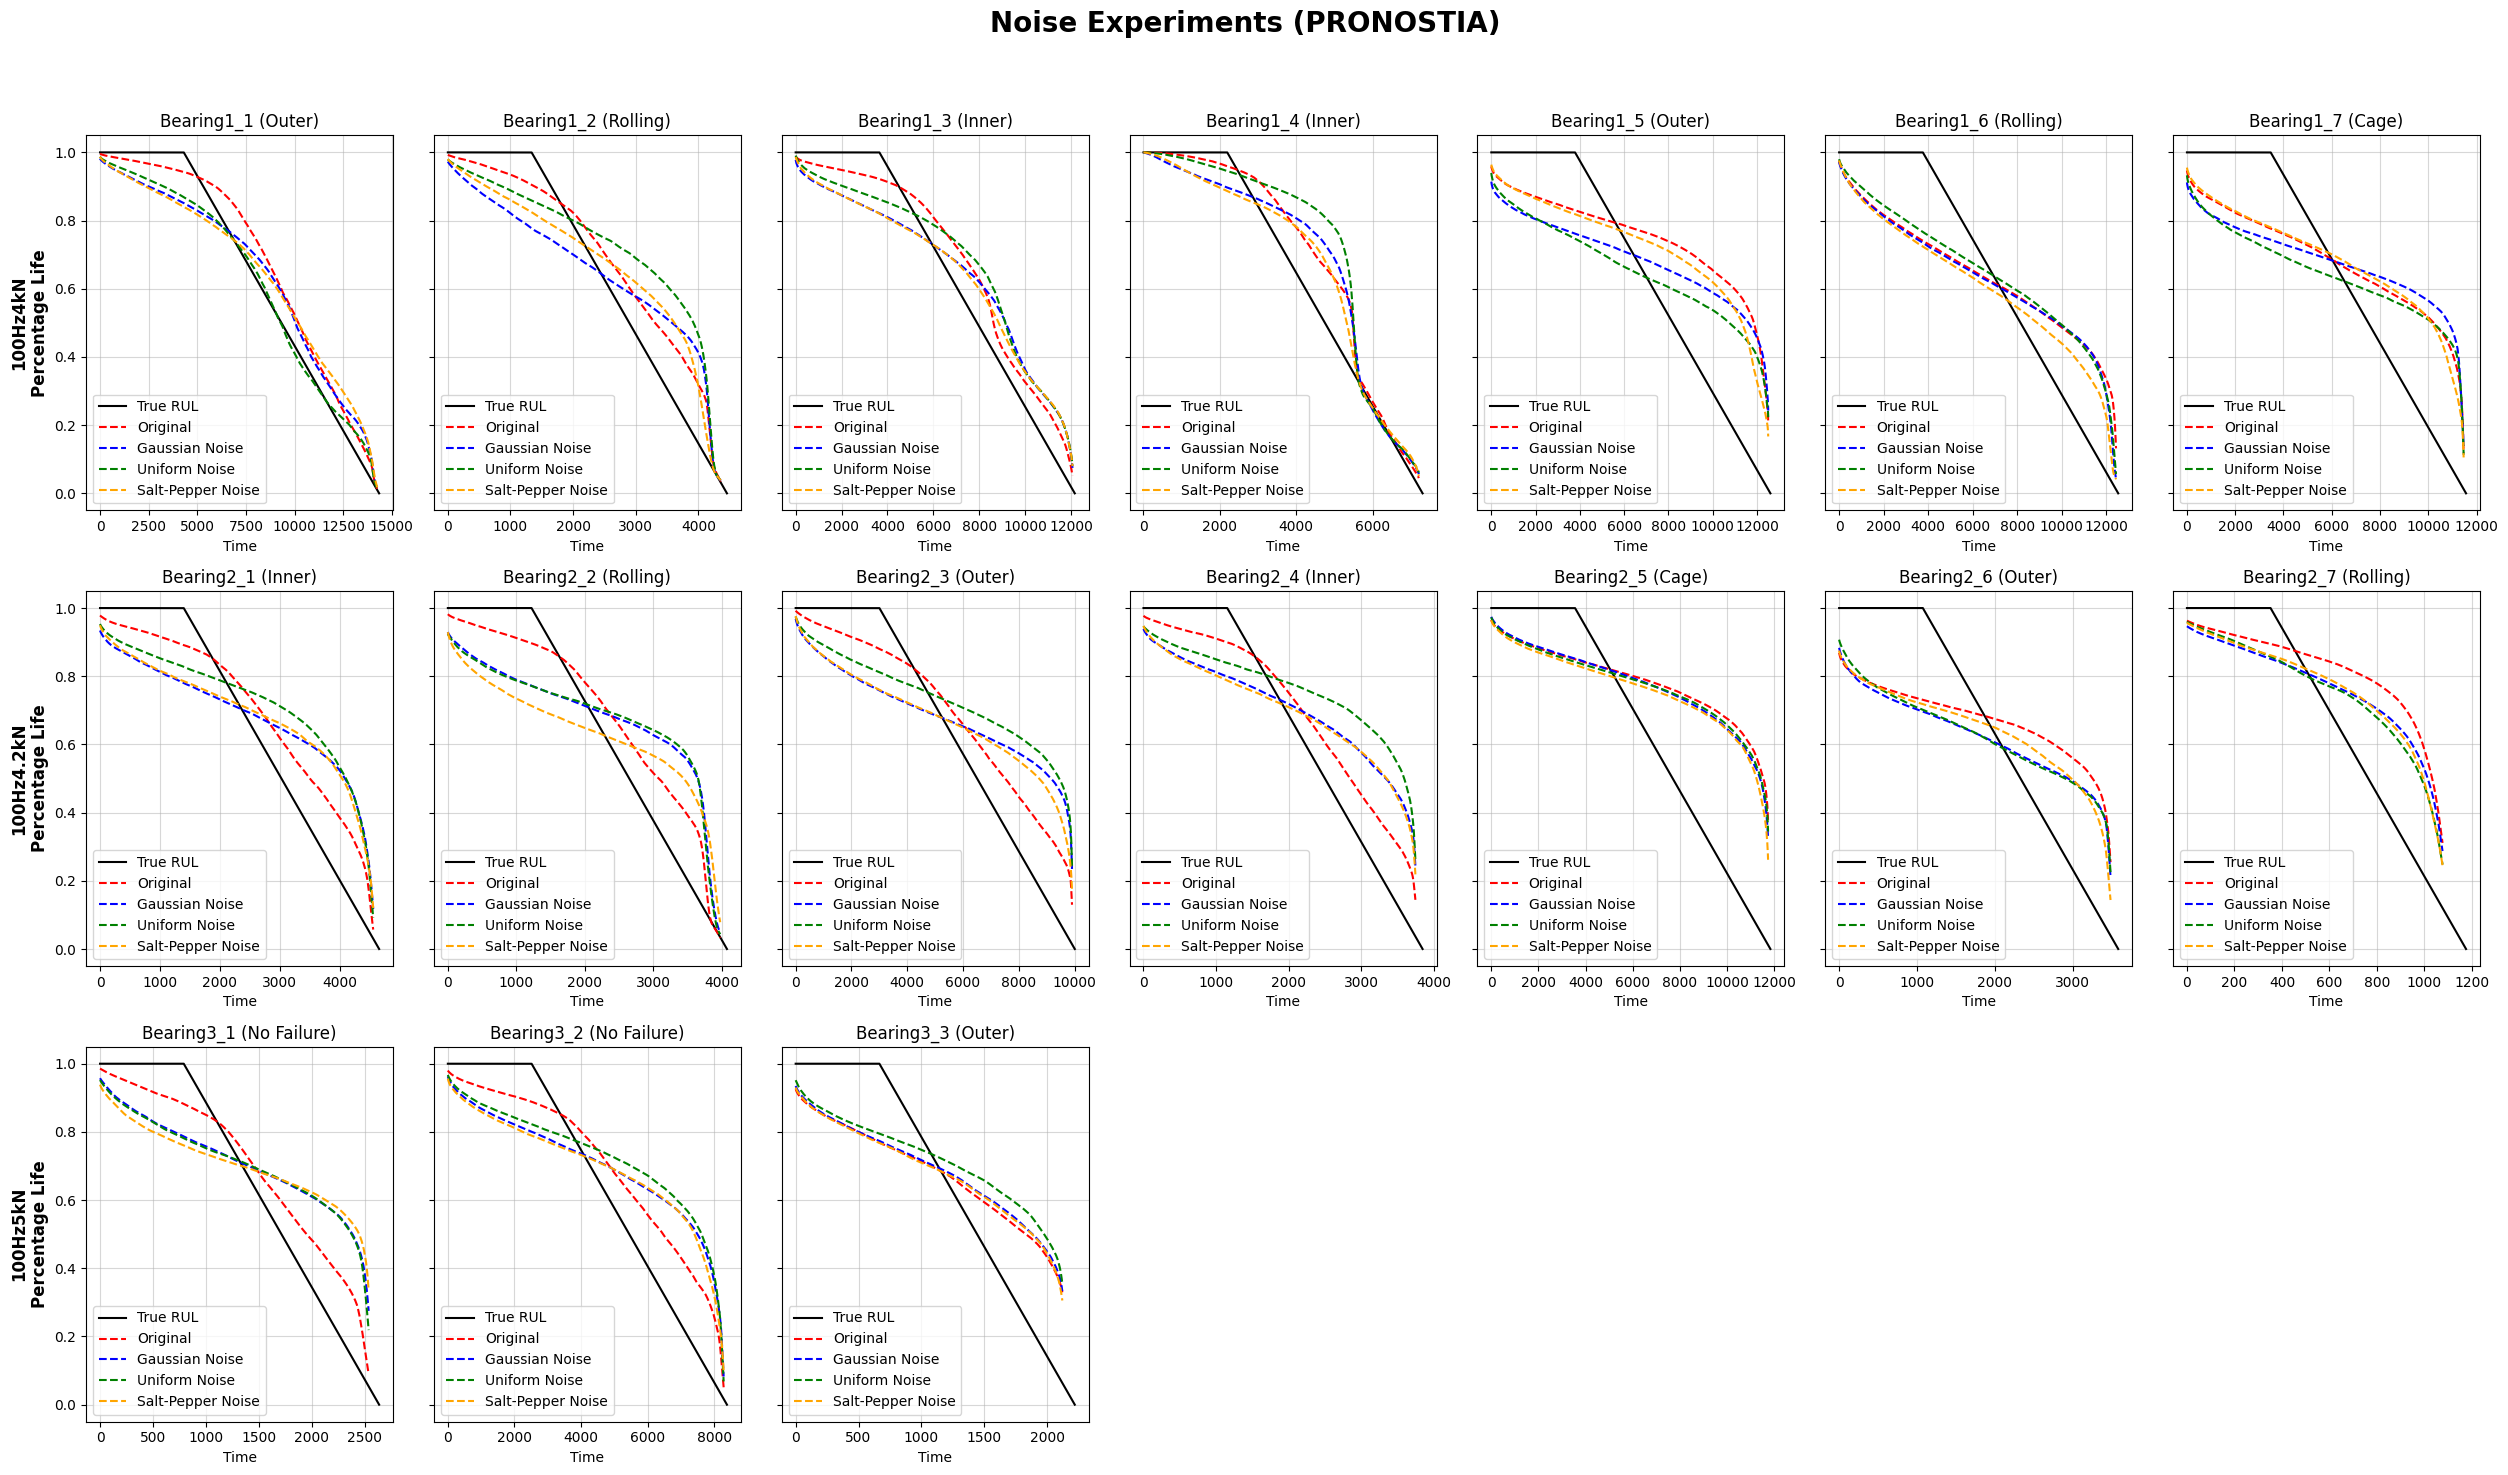

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model, load_model
from utils.preprocess import process_features,correct_dims3
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from multimodal import multimod_rul
from ablation_multimodal import mmv1,mmv2,mmv3

# Seed for reproducibility
np.random.seed(100)

# Define noise generation functions
def add_gaussian_noise(data, mean=0, std_dev=0.03):
    gaussian_noise = np.random.normal(mean, std_dev, size=data.shape)
    return data + gaussian_noise

def add_uniform_noise(data, low=-0.003, high=0.05):
    uniform_noise = np.random.uniform(low, high, size=data.shape)
    return data + uniform_noise

def add_salt_pepper_noise(data, prob=0.1, sp_value=0.2):
    sp_noise = np.zeros_like(data)
    for i in range(len(sp_noise)):
        if np.random.random() < prob:
            sp_noise[i] = np.random.choice([0, sp_value])  # Black or white
    return data + sp_noise


def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Load directories
dir = os.getcwd()
image_dir = os.path.join(dir, 'image_features')
time_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')

# Define bearing conditions
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer'},
        {'name': 'Bearing1_2', 'failure': 'Rolling'},
        {'name': 'Bearing1_3', 'failure': 'Inner'},
        {'name': 'Bearing1_4', 'failure': 'Inner'},
        {'name': 'Bearing1_5', 'failure': 'Outer'},
        {'name': 'Bearing1_6', 'failure': 'Rolling'},
        {'name': 'Bearing1_7', 'failure': 'Cage'},
    ],
    '100Hz4.2kN': [
        {'name': 'Bearing2_1', 'failure': 'Inner'},
        {'name': 'Bearing2_2', 'failure': 'Rolling'},
        {'name': 'Bearing2_3', 'failure': 'Outer'},
        {'name': 'Bearing2_4', 'failure': 'Inner'},
        {'name': 'Bearing2_5', 'failure': 'Cage'},
        {'name': 'Bearing2_6', 'failure': 'Outer'},
        {'name': 'Bearing2_7', 'failure': 'Rolling'},
    ],
    '100Hz5kN': [
        {'name': 'Bearing3_1', 'failure': 'No Failure'},
        {'name': 'Bearing3_2', 'failure': 'No Failure'},
        {'name': 'Bearing3_3', 'failure': 'Outer'},
    ]
}

# Load model and weights
model = multimod_rul()
model.load_weights(f'{weights_dir}/pronosita_multimodal_weights.hdf5.keras')
model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)  
regressor = joblib.load(f'{weights_dir}/pronosita_multimodal_skl.pkl')


error_data = []

# Prepare subplots
plt.style.use('seaborn-v0_8-deep')
rows = len(bearings)
columns = max(len(bearing_list) for bearing_list in bearings.values())
fig, axes = plt.subplots(rows, columns, figsize=(25, 5 * rows), sharey=True)
fig.suptitle('Noise Experiments (PRONOSTIA)', fontsize=20, fontweight='bold')

# Loop through conditions and bearings
for row, (condition, bearing_list) in enumerate(bearings.items()):
    for col in range(columns):
        if col < len(bearing_list):  # Populate only for existing bearings
            bearing_info = bearing_list[col]
            bearing = bearing_info['name']
            failure = bearing_info['failure']

            try:
                df = pd.read_csv(f'{time_dir}/{bearing}_features.csv')

                vertical_features = np.array(df['Vertical'].apply(eval).tolist())
                X_time = process_features(vertical_features)
                y_true = df['RUL'].values / np.max(df['RUL'].values)


                X_images = np.load(f'{image_dir}/{bearing}_horizontal_images.npy')
                X_images = np.array([correct_dims3(data) for data in X_images])

                y_true = df['RUL'].values / np.max(df['RUL'].values)

                # Add noise to inputs
                gaussian_X_time = add_gaussian_noise(X_time)
                uniform_X_time = add_uniform_noise(X_time)
                sp_X_time = add_salt_pepper_noise(X_time)

                gaussian_X_images = np.array([add_gaussian_noise(image) for image in X_images])
                uniform_X_images = np.array([add_uniform_noise(image) for image in X_images])
                sp_X_images = np.array([add_salt_pepper_noise(image) for image in X_images])

                # Predictions for noisy inputs
                logit_vec_original = model.predict([X_images, X_time]).squeeze()
                logit_vec_gaussian = model.predict([gaussian_X_images, gaussian_X_time]).squeeze()
                logit_vec_uniform = model.predict([uniform_X_images, uniform_X_time]).squeeze()
                logit_vec_sp = model.predict([sp_X_images, sp_X_time]).squeeze()

                # Predict RUL
                prediction_original = regressor.predict(logit_vec_original).squeeze()
                prediction_gaussian = regressor.predict(logit_vec_gaussian).squeeze()
                prediction_uniform = regressor.predict(logit_vec_uniform).squeeze()
                prediction_sp = regressor.predict(logit_vec_sp).squeeze()

                # Sort predictions
                prediction_original = np.sort(prediction_original.squeeze())[::-1]
                prediction_gaussian = np.sort(prediction_gaussian.squeeze())[::-1]
                prediction_uniform = np.sort(prediction_uniform.squeeze())[::-1]
                prediction_sp = np.sort(prediction_sp.squeeze())[::-1]


                # Plot all signals
                axes[row, col].plot(y_true, label='True RUL', color='black', linestyle='-')
                axes[row, col].plot(moving_average(prediction_original), label='Original', color='red', linestyle='--')
                axes[row, col].plot(moving_average(prediction_gaussian), label='Gaussian Noise', color='blue', linestyle='--')
                axes[row, col].plot(moving_average(prediction_uniform), label='Uniform Noise', color='green', linestyle='--')
                axes[row, col].plot(moving_average(prediction_sp), label='Salt-Pepper Noise', color='orange', linestyle='--')

                axes[row, col].set_title(f'{bearing} ({failure})')
                axes[row, col].grid(alpha=0.5)
                axes[row, col].legend(loc='best')
                axes[row, col].set_xlabel('Time')
                if col == 0:  # Set ylabel for first column only
                    axes[row, col].set_ylabel(f'{condition}\nPercentage Life', fontsize=12, fontweight='bold')
            except Exception as e:
                print(f"Error processing {bearing}: {e}")
        else:  # Clear unused subplots
            axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

STEP 12: Comparison with State-of-the-art models

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from comparison import CNN_LSTM,CNN_BiLSTM,MSIDISN
from utils.preprocess import process_features,correct_dims3
from keras._tf_keras.keras.models import Model,load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Fixed missing imports



bearings = {
    '100Hz4kN': ['Bearing1_1', 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7'],
    '100Hz4.2kN': ['Bearing2_1', 'Bearing2_2', 'Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7'],
    '100Hz5kN': ['Bearing3_1', 'Bearing3_2', 'Bearing3_3']
}


dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
image_dir = os.path.join(dir, 'image_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir,'statistics')

cnn_lstm = CNN_LSTM()
cnn_lstm.load_weights(f'{weights_dir}/pronosita_CARLE_cnn_lstm.h5')

cnn_bilstm = CNN_BiLSTM()
cnn_bilstm.load_weights(f'{weights_dir}/pronosita_CARLE_cnn_bilstm.h5')

msidin = MSIDISN()
msidin.load_weights(f'{weights_dir}/pronosita_CARLE_msidin.h5')

carle_keras = load_model(f'{weights_dir}/pronostia_CARLE_weights.keras')
carle_extractor = Model(inputs=carle_keras.input, outputs=carle_keras.get_layer(index=-2).output)
carle_regressor = joblib.load(f'{weights_dir}/pronostia_CARLE_skl.pkl')

mmv_keras = multimod_rul()
mmv_keras.load_weights(f'{weights_dir}/pronosita_multimodal_weights.hdf5.keras')
mmv_extractor = Model(inputs=mmv0_keras.input, outputs=mmv0_keras.get_layer(index=-2).output)  
mmv_regressor = joblib.load(f'{weights_dir}/pronosita_multimodal_skl.pkl')

error_data = []

# Loop through conditions and bearings
for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
           df = pd.read_csv(f'{feature_dir}/{bearing}_features.csv')

           horizontal_features = np.array(df['Horizontal'].apply(eval).tolist())
           X_time_H = process_features(horizontal_features)

           X_images = np.load(f'{image_dir}/{bearing}_horizontal_images.npy')
           X_images = np.array([correct_dims3(data) for data in X_images])

           vertical_features = np.array(df['Vertical'].apply(eval).tolist())
           X_time_V = process_features(vertical_features)

           y_true = df['RUL'].values / np.max(df['RUL'].values)

           X = np.concatenate((X_time_H, X_time_V), axis=-1)
           X = correct_dims3(X)
           pred_msidin = msidin.predict(X).squeeze()
           pred_cnn_lstm = cnn_lstm.predict(X).squeeze()
           pred_cnn_bilstm = cnn_bilstm.predict(X).squeeze()
           carle_logitX = carle_extractor.predict(X)
           pred_carle = carle_regressor.predict(carle_logitX).squeeze()
           mm_logitX = mmv_extractor.predict([X_images,X_time_V]).squeeze()
           pred_mmv = mmv_regressor.predict(mmv0_X).squeeze()


           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "CARLE",
                "Mean Squared Error": mean_squared_error(y_true, pred_carle),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_carle)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "CNN-LSTM",
                "Mean Squared Error": mean_squared_error(y_true, pred_cnn_lstm),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_cnn_lstm)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "CABiLSTM",
                "Mean Squared Error": mean_squared_error(y_true, pred_cnn_bilstm),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_cnn_bilstm)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "MSIDIN",
                "Mean Squared Error": mean_squared_error(y_true, pred_msidin),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_msidin)
            })
           error_data.append({
                "Condition": condition,
                "Bearing": bearing,
                "Model": "Proposed",
                "Mean Squared Error": mean_squared_error(y_true, pred_mmv),
                "Mean Absolute Error": mean_absolute_error(y_true, pred_mmv)
            })
        except Exception as e:
            print(f"Error processing {bearing}: {e}")

# Convert error data to DataFrame and save as CSV grouped by condition
df_errors = pd.DataFrame(error_data)
df_errors.to_csv(f'{stats_dir}/pronostia_multimodal_SOTA.csv', index=False)

print("Idea 2: State-of-the-art models comparison saved.csv")


/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.2 when using version 1.3.0. This might

449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
380/380 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
3

STEP 13: LRP Explanations

2025-05-27 19:02:44.586905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 19:02:44.587866: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 19:02:44.590869: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 19:02:44.599074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748343764.612386    9180 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748343764.61

6071


I0000 00:00:1748343767.838595    9180 service.cc:148] XLA service 0x8430490 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748343767.838647    9180 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1748343767.859376    9180 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


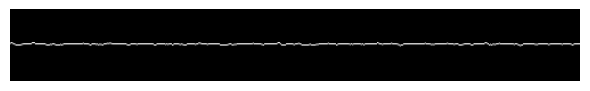

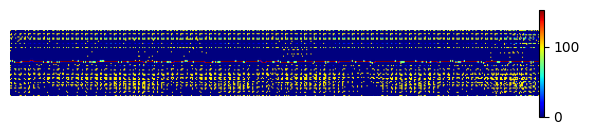

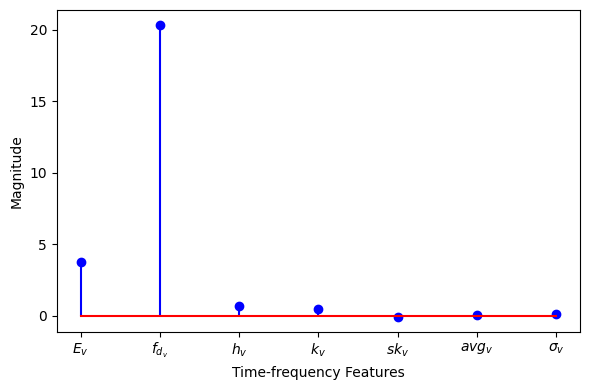

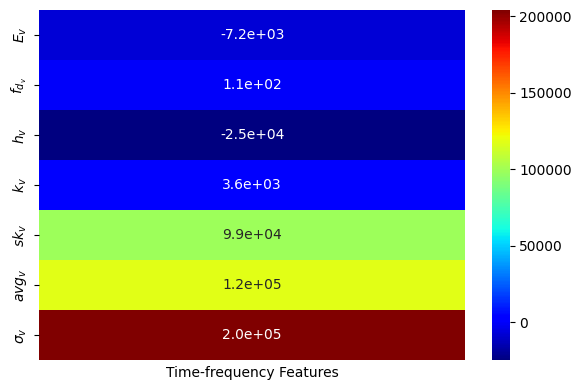

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras._tf_keras.keras.models import Model
from lrp.lrp import LRP
from multimodal import multimod_rul
from utils.preprocess import process_features, correct_dims2


x_names = [r"$E_{v}$", r"$f_{d_{v}}$", r"$h_{v}$", r"$k_{v}$", r"$sk_{v}$", r"$avg_{v}$", r"$\sigma_{v}$"]

dir = os.getcwd()
image_dir = os.path.join(dir, 'image_features')
time_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')

def explain_multimodal(lrp_models, inputs, class_index=0):
    image_model, time_model, fusion_model = lrp_models
    image_input, time_input = inputs

    image_output, image_residual = image_model.forward(image_input)
    time_output, time_residual = time_model.forward(time_input)
    fusion_output, fusion_residual = fusion_model.forward([image_output.squeeze(), time_output.squeeze()])

    R = np.zeros_like(fusion_output)
    R[0, class_index] = 1  
    relevance = fusion_model.backward(R, fusion_residual)
    image_relevance = image_model.backward(relevance[0], image_residual)
    time_relevance = time_model.backward(relevance[1], time_residual)

    return image_relevance, time_relevance

# Load the trained model
model = multimod_rul(img_shape=(500, 63, 1), time_shape=(7, 1))
model.load_weights(f'{weights_dir}/pronosita_multimodal_weights.hdf5.keras')

# Define LRP models
image_branch = Model(inputs=model.input[0], outputs=model.get_layer('reshape').output)  
time_branch = Model(inputs=model.input[1], outputs=model.get_layer('tres2').output)  
fusion_branch = Model(inputs=model.get_layer('mres1ip').input, outputs=model.get_layer(index=-2).output)

lrp_image = LRP(image_branch)
lrp_time = LRP(time_branch)
lrp_fusion = LRP(fusion_branch)

bearings = {'Bearing1_1', 
            # 'Bearing1_2', 'Bearing1_3', 'Bearing1_4', 'Bearing1_5'
            }

# Process each bearing
for bearing in sorted(bearings):
    df = pd.read_csv(f'{time_dir}/{bearing}_features.csv')

    vertical_features = np.array(df['Vertical'].apply(eval).tolist())
    X_time = process_features(vertical_features)
    y_true = df['RUL'].values / np.max(df['RUL'].values)

    X_images = np.load(f'{image_dir}/{bearing}_horizontal_images.npy')
    random_index = np.random.randint(0,len(X_time))
    print(random_index)

    image_input = correct_dims2(X_images[random_index])
    time_input = correct_dims2(X_time[random_index])

    image_relevance, time_relevance = explain_multimodal([lrp_image, lrp_time, lrp_fusion], [image_input, time_input], class_index=0)

    # Normalize image and relevance
    max_val = np.max(image_input)
    image_uint8 = np.uint8(255 * (image_input[0, :, :, 0] / max_val)) if max_val > 0 else np.zeros_like(image_input, dtype=np.uint8)

    max_rel = np.max(image_relevance)
    relevance_scores_normalized = np.uint8(255 * (image_relevance[0, :, :, 0] / max_rel)) if max_rel > 0 else np.zeros_like(image_relevance[0, :, :, 0], dtype=np.uint8)

    # Overlay relevance on image
    overlay = cv2.addWeighted(image_uint8, 0.6, relevance_scores_normalized, 0.4, 0)

    # **Image Plot 1: Original Image**
    fig1 = plt.figure(figsize=(6, 4))
    plt.imshow(image_uint8, cmap='gray')
    # plt.title(f"Original Image - {bearing}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # **Image Plot 2: Relevance Overlay**
    fig2 = plt.figure(figsize=(6, 4))
    plt.imshow(overlay, cmap='jet')
    plt.colorbar(fraction=0.01, pad=0.001)  # Adjust fraction and pad for better fit
    # plt.title(f"Image Relevance - {bearing}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # **Time Plot 1: Time Features - Stem Plot**
    fig3 = plt.figure(figsize=(6, 4))
    plt.stem(x_names, time_input.squeeze(), linefmt='b-', markerfmt='bo', basefmt='r-')
    # plt.title(f"Time Features - {bearing}")
    plt.xlabel("Time-frequency Features")
    plt.ylabel("Magnitude")
    plt.tight_layout()
    plt.show()

    time_relevance = time_relevance.reshape(-1, 1)  # Shape (7, 1)
    fig4 = plt.figure(figsize=(6, 4))
    sns.heatmap(time_relevance, annot=True, cmap="jet", cbar=True, fmt='.1e', xticklabels=False, yticklabels=x_names)
    plt.xlabel("Time-frequency Features")
    # plt.title(f"Relevance Heat map- {bearing}")
    plt.tight_layout()
    plt.show()
